## Introduction

In this post we'll look at using Monte Carlo Markov Chains to estimate the population proportion from a sample of data.

### Monte Carlo Markov Chain Sampling

Monte Carlo Markov Chain (MCMC) sampling is a computational method for examining the 'shape' of our posterior distribution without having to calculate the whole distribution. It's basically a memoryless random walk over the posterior distribution. MCMC is an useful method to use to characterise the posterior distribution when we don't know the form of the posterior (and therefore analytic methods are not available to us) or where the grid approach would be computationally unfeasible (it would take too long). Essentially MCMC samples the posterior distribution, generating a representative sample from this distribution which we can then use to characterise the distribution. The [Robot Metaphor](http://mcmcrobot.org/) provides a nice visual interpretation of MCMC sampling.

![img](http://marple.eeb.uconn.edu/mcmcrobot/wp-content/uploads/2012/09/robotsrules1.png)

If you want to read more about the MCMC process then the [mcmcrobot](http://mcmcrobot.org/) site is a good starting point.

### The Data
The data we'll use is proportion of students getting a 1st class mark in a module I teach to third year students at the University of Stirling. We have data for the years 2010 to 2015 on the total number of students who took the module and whether they got a first class mark or not. 

Programmes written to carry out MCMC sampling mean that we don't have to worry about the specifics of the sampling procedure. In this post we'll use [JAGS](http://mcmc-jags.sourceforge.net/) to do the heavy lifting of MCMC sampling for us. JAGS has an interface to R called [```rjags```](https://cran.r-project.org/web/packages/rjags/index.html). Using ```rjags``` means we won't have to step outside R to carry out our analysis. In order to follow along you'll need to install ```JAGS``` and the R packages used below.

First of all we have to load the packages we want to use and the data we will analyse. As well as ```rjags``` we load the ```coda``` package which will allow us to plot various diagnostic plots to ensure the MCMC process ran smoothly.

In [2]:
library(rjags)
library(coda)

# get the data
data_in <- read.table('data/c5_firsts.csv', header=TRUE, sep=',')

### The model

The parameter we are interested in calcuating here is the proportion of students who will get a first class mark so we will define a first class mark as a success and anything else as a failure (harsh!). We will denote the proportion of first class marks as $\theta$ and model our data as binomially distributed. The binomial distribution gives me the probability of getting $s$ successes in $n$ trials and has two parameters, $\theta$ - the probability of success (what we're trying to estimate here) and $n$ - the number of trials.

The formula for the binomial probability distribution is:

$P(s) = {n \choose s}\theta^s(1-\theta)^{n-s}$

The ${n\choose s}$ part is called the binomial coefficient and is calculated by $\frac{n!}{s!(n-s)!}$.

Thus our data is binomially distributed:

$$y \sim binomial(\theta, n)$$

Given the model above we want to estimate the distribution of $\theta$. What we have to hand is the number of successes and the number of failures and therefore the total number of trials.

Since we want to estimate a posterior distribution over $\theta$ we'll need some prior distribution to begin with. We would like a continuous distribution as the prior over $\theta$ and one very resaonable choice is the beta distribution. The beta distribution has two parameters, $a$ and $b$ and is denoted as beta$(a,b)$. The density of the beta distribution over a parameter $\theta$ has the form:

$$p(\theta| a,\ b) = \frac{\theta^{a-1}(1-\theta)^{b-1}}{B(a,b)}$$

where $B(a,b)$ is the Beta function and acts as a normalising constant to ensure the area under the curve of the beta distribution sums to 1. The Beta function is:

$$B(a,\ b) = \int_0^1 d\theta\ \theta^{a-1}(1-\theta)^{b-1}$$

### Shape of the beta distribution

The first parameter of the beta distribution, $a$, can be thought of as the mode of the distribution i.e. where most of our probability will pile up. In this sense $a$ can be considered the 'number of successes' we've seen. If there have been a lot of successes then the beta distribution will pile more probability closer to 1 (if 1 is the code for success). The sum, $a+b$, controls the spread of the distribution and could be thought of as the 'amount of evidence' I've previously seen to support my 'belief' in a particular probability of success. As $a$ and $b$ get bigger the sum $a+b$ gets bigger and the distribution gets narrower representing less doubt in my belief. If $a$ and $b$ are the same number and > 1 then the distribution is symmetrical around 0.5. If $a = b = 1$ then we have a uniform distribution. We don't have any preconceptions about the values of $a$ or $b$ so we will place uniform priors on these parameters with lower and upper limits of 1 and 100 respectively.

The hierarchical model of our data will be:

$$y \sim binomial(\theta, n)$$
$$\theta \sim beta(a, b)$$
$$a,b \sim unif(L, H)$$


The structure of this model can be visualised using a 'Kruschke' diagram:

<img src="./pics/beta_binom_uniform_priors.png" alt="Beta-binomial hierarchical model" style="width: 300px;"/>

These diagrams are meant to be read from the bottom up. The $y_{i}$ at the bottom is the data to hand, this is modelled as binomially distributed with parameters $\theta$ and $n$. There is a beta prior on $\theta$ with parameters $a$ and $b$. The parameters of the beta distribution each have a uniform prior with a lower (L) and upper (U) limit. This diagram was created with the ['Kruschke' diagram templates](http://www.sumsar.net/blog/2013/10/diy-kruschke-style-diagrams/) created by Rasmus Bååth. Thanks Rasmus! For more on the diagrams themselves see John Kruschke's blog [here](http://doingbayesiandataanalysis.blogspot.se/2012/05/graphical-model-diagrams-in-doing.html), [here](http://doingbayesiandataanalysis.blogspot.se/2012/05/hierarchical-diagrams-read-bottom-to.html) and [here](http://doingbayesiandataanalysis.blogspot.se/2013/10/diagrams-for-hierarchical-models-we.html) or the excellent [Doing Bayesian Data Analysis](https://www.amazon.com/Doing-Bayesian-Data-Analysis-Second/dp/0124058884/ref=pd_sim_14_4/175-3727340-1932110?ie=UTF8&dpID=51Jt%2BWN9MqL&dpSrc=sims&preST=_AC_UL320_SR262%2C320_&refRID=A66M1G4JWJGZ6MTF6MFB).

In order to use ```JAGS``` we have to define our model in a way that ```JAGS``` understands it. Kruschke makes the point that diagrams like the one above make it easier to define a model in ```JAGS``` because each arrow in the diagram corresponds to a section in the model specification in ```JAGS```. We'll see that below.

### Running the model

To use the ```rjags``` library we first need to organise our data into a list structure so we can send it to ```JAGS```. Below we define a list that contains the total number of successes, the total number of trials and the parameters for our uniform prior distribution over $\theta$.

In [3]:
ten <- subset(data_in, data_in$year=='2010')
succ <- sum(ten$first)
N <- length(ten$first)
# create a list structure containing the data we need
data_list <- list(y = succ, Ntotal = N, L = 1, H = 100)
data_list

$y
[1] 4

$Ntotal
[1] 61

$L
[1] 1

$H
[1] 100

We next need to tell ```JAGS``` about the structure of our model. We create a string that describes the model. Notice that, as pointed out above, each arrow in our Kruschke diagram is represented in the model specification for ```JAGS```. Our data is distributed binomially, $\theta$ has a beta distribution and the $a$ and $b$ parameters of the beta distribution have uniform distributions over them. To send the model to ```JAGS``` we can either save the model specification to an external file or send the model string directly to ```JAGS``` via a text connection. In the example below the commented out part shows the latter approach but I opted for the text file approach in this example.

The lines that include ```dunif```, ```dbeta``` and ```dbinom``` specify the probability models for ```JAGS``` to use. You can see the available models in the 'Distributions' chapter of the ```JAGS``` [manual](https://sourceforge.net/projects/mcmc-jags/files/Manuals/4.x/). Finally we write the model definition out to a separate text file and we'll use that text file via ```rjags``` in a call to the ```JAGS``` programme.

In [4]:
modelString = "model {
  
  a ~ dunif(L, H) # priors on a & b
  b ~ dunif(L, H)
  theta ~ dbeta(a, b) # uninformative prior on theta
  y ~ dbin(theta, Ntotal) # likelihood
}
"

writeLines(modelString, con="TEMPmodel.txt") # write to external file
# direct call to jags.model function
# model <- jags.model(textConnection(model_string), data = list(y = succ, Ntotal = N, L = 1, H = 100))

The ```writeLines``` command simply sends the string to the external file ```TEMPmodel.txt```. If the file doesn't exist then it's created. Next we have to tell ```JAGS``` to compile our model.

In [5]:
# compile model
jagsModel <- jags.model(file='TEMPmodel.txt', data=data_list, n.chains=3, n.adapt=500)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 1
   Unobserved stochastic nodes: 3
   Total graph size: 7

Initializing model



Note that this does not actually run the model - it only serves to tell ```JAGS``` to compile the model to C code. We have specified the text file describing the model, the R list containing the data, the number of chains - 3 in this case, and the number of steps to take to tune the sampler in the MCMC process. The ```jags.model``` command creates an object of class ```jags```.

When running MCMC it's important to set a 'burn in' period for each chain since early samples might be correlated with each other. We therefore update our model by setting 500 steps in each chain as the burn in. These steps will be ignored 

In [6]:
# set burn in 500
update(jagsModel, n.iter=500)

Updating the ```jagsModel``` object like this only changes the state of the object and doesn't return any values to us and the sampled parameter values generated during this tuning are not recorded. The 'burn in' reduces the possibility of early autocorrelation between steps in the MCMC from biasing our parameter estimate.

Next we run the MCMC process. The parameter estimates from each chain are recorded and organised into an R object that can be accessed using the [```coda```](https://cran.r-project.org/web/packages/coda/index.html) package which has functions for summarising and visualising the output from ```JAGS``` MCMC simulations.

In [7]:
# run the MCMC
codaSamples <- coda.samples(jagsModel, variable.names=c('theta'), n.iter=5000) # only return info for theta

Once we've run the model we can examine various aspects. First we'll have a look at the object we'll be dealing with, examine the first few entries in the first MCMC chain and then examine a structural summary of the first MCMC chain.

In [8]:
str(codaSamples)
head(codaSamples[[1]])

List of 3
 $ : mcmc [1:5000, 1] 0.1083 0.079 0.0865 0.1659 0.0756 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr "theta"
  ..- attr(*, "mcpar")= num [1:3] 1001 6000 1
 $ : mcmc [1:5000, 1] 0.0305 0.0529 0.0782 0.0518 0.0522 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr "theta"
  ..- attr(*, "mcpar")= num [1:3] 1001 6000 1
 $ : mcmc [1:5000, 1] 0.1371 0.1184 0.0842 0.1166 0.0666 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr "theta"
  ..- attr(*, "mcpar")= num [1:3] 1001 6000 1
 - attr(*, "class")= chr "mcmc.list"


Markov Chain Monte Carlo (MCMC) output:
Start = 1001 
End = 1007 
Thinning interval = 1 
          theta
[1,] 0.10831310
[2,] 0.07900844
[3,] 0.08645550
[4,] 0.16592206
[5,] 0.07558354
[6,] 0.05098836
[7,] 0.04897807

We can see that the ```codaSamples``` object is a 'list of lists' object. There are 3 lists in this object representing the 3 MCMC chains we generated. Each list contains the MCMC generated values that characterise our posterior distribution over $\theta$ as well as a character vector telling us which parameter we have selected to examine MCMC data on, here $\theta$.

In [9]:
attributes(codaSamples[[1]]) # [[2]] or [[3]] would show info for 2nd/3rd chains respectively

$dim
[1] 5000    1

$dimnames
$dimnames[[1]]
NULL

$dimnames[[2]]
[1] "theta"


$mcpar
[1] 1001 6000    1

$class
[1] "mcmc"

We can easily get a summary of our parameter estimate. 

In [10]:
summary(codaSamples)


Iterations = 1001:6000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 5000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
     0.0832523      0.0346746      0.0002831      0.0005718 

2. Quantiles for each variable:

   2.5%     25%     50%     75%   97.5% 
0.02850 0.05779 0.07853 0.10377 0.16322 


We can see that the mean value of $\theta$ is 0.08 and $\theta$ has a standard deviation of 0.03. The ```Quantiles for each variable``` section displays a five number summary based on the MCMC sampling. We can see from this that 95% of the probability we would assign to $\theta$ values lies between 0.028 and 0.161. Kruschke calls this interval the 95% [highest density interval](http://doingbayesiandataanalysis.blogspot.co.uk/2012/04/why-to-use-highest-density-intervals.html) (HDI). 

We can also examine a density plot of the estimated posterior for $\theta$ to which we've added the 95% HDI as a coloured line below.

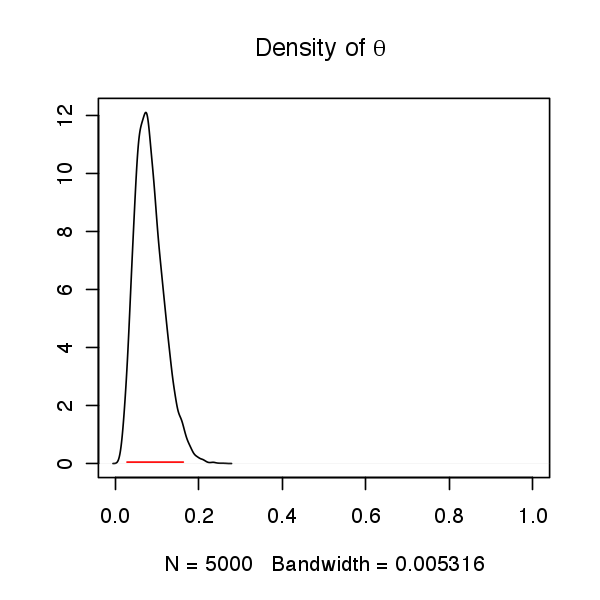

In [11]:
options(repr.plot.width=5, repr.plot.height=5) # plot sizing
low_val <- summary(codaSamples)$quantiles[[1]] # 2.5% quantile for values
hi_val <- summary(codaSamples)$quantiles[[5]] # 97.5% quantile for values

twen_ten_posterior <- densplot(codaSamples, show.obs=FALSE, main=expression(paste('Density of ', theta, sep=' ')), xlim=c(0,1))
lines(x=c(low_val, hi_val), y=c(0.05, 0.05), col='red')

We should also check that the MCMC traces look reasonable. The chains should overlap there should be no obvious sytematic deviation from around our estimated parameter. I've saved this as an image in the code below because it's a very dense plot and locks up the jupyter notebook I used to write this post.

In [12]:
png("./pics/MCMC_trace.png", width=1000, height=500)
traceplot(codaSamples)
dev.off()

pdf 
  2

<img src="./pics/MCMC_trace.png" alt="MCMC trace plot" style="width: 800px;"/>

In this case all the chains look fine.

We can also examine the chains for the $a$ and $b$ parameters we used to parameterise our beta distribution.


Iterations = 6001:11000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 5000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
       7.29818        4.55826        0.03722        0.10032 

2. Quantiles for each variable:

  2.5%    25%    50%    75%  97.5% 
 1.453  3.910  6.374  9.613 18.310 



Iterations = 11001:16000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 5000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
       67.6110        23.1067         0.1887         0.4108 

2. Quantiles for each variable:

 2.5%   25%   50%   75% 97.5% 
17.06 51.61 71.82 86.97 98.72 


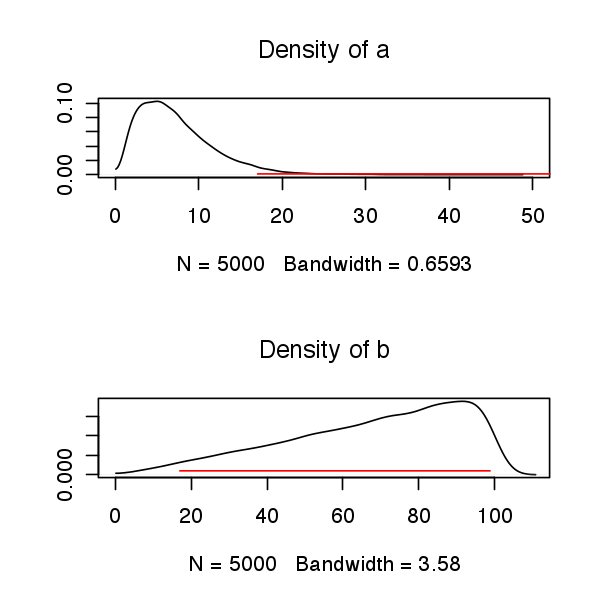

In [13]:
a <- coda.samples(jagsModel, variable.names=c('a'), n.iter=5000)
b <- coda.samples(jagsModel, variable.names=c('b'), n.iter=5000)

low_val <- summary(a)$quantiles[[1]] # 2.5% quantile for values
hi_val <- summary(a)$quantiles[[5]] # 97.5% quantile for values
summary(a)

low_val <- summary(b)$quantiles[[1]] # 2.5% quantile for values
hi_val <- summary(b)$quantiles[[5]] # 97.5% quantile for values
summary(b)

par(mfrow=c(2,1))
a_posterior <- densplot(a, show.obs=FALSE, main='Density of a', xlim=c(0,50))
lines(x=c(low_val, hi_val), y=c(0.001, 0.001), col='red')

b_posterior <- densplot(b, show.obs=FALSE, main='Density of b', xlim=c(0,110))
lines(x=c(low_val, hi_val), y=c(0.001, 0.001), col='red')

We will also examine the traceplots.

In [ ]:
png("./pics/MCMC_trace_a_b.png", width=1000, height=500)
par(mfrow=c(2,1))
traceplot(a); traceplot(b)
dev.off()

<img src="./pics/MCMC_trace_a_b.png" alt="MCMC trace plot" style="width: 800px;"/>